In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using CategoricalArrays
# using ScikitLearn
using ShapML
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using UMAP
# using LayeredLayouts

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

shap = pyimport("shap")

xgboost = pyimport("xgboost");

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [6]:
# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_beta_1_mg_250k.jld2"));

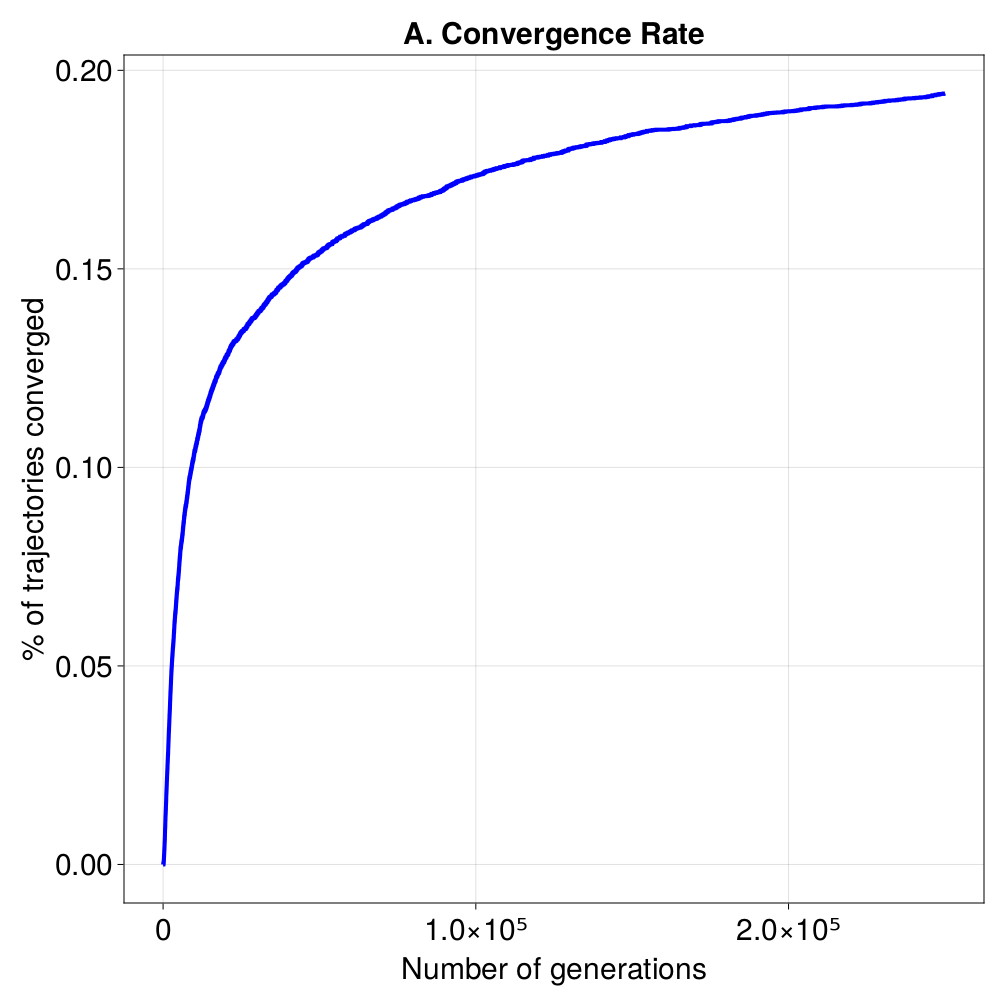

In [7]:
conv = copy(data["converged"]);

conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [8]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj_add = map(t->map(x->x[2]+x[1],unique(t)),fitness_traj_b);

fitness_traj = map(x->unique(x),fitness_traj_b)

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

initial_fitness_add = fitness_traj_add[1][1];

initial_genotype = geno_traj[1][:,1];

In [9]:
n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

In [10]:
all_networks = reduce(hcat,geno_traj)

all_top = sign.(all_networks)

12×38299 Matrix{Float64}:
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0  -1.0  -1.0  -1.0  -1.0      0.0   1.0   1.0   1.0   1.0   1.0
  0.0   0.0   0.0   0.0   0.0   0.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   1.0   1.0   1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   1.0   1.0   1.0   1.0   1.0      1.0   1.0   1.0   1.0   1.0   1.0
  1.0   1.0   1.0   1.0   1.0   1.0      1.0   1.0   1.0   1.0   1.0   1.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0

In [11]:
uniqueidx(x) = unique(i -> x[:,i], 1:size(x,2))

ut = unique(all_top,dims = 2);

unique_top_id = uniqueidx(all_top)

@assert all_top[:,unique_top_id] == ut

In [12]:
complexity_ut = [sum(abs.(top)) for top in eachcol(ut)];

sorted_complexity_ut = sort(complexity_ut)

sorted_ut = ut[:,sortperm(complexity_ut)];

In [13]:
ut_map_dict = Dict(t=>n for (n,t) in enumerate(eachcol(sorted_ut)));

all_top_ut_map = map(x->ut_map_dict[x],eachcol(all_top));

In [14]:
fitness_indicator = reduce(vcat,map(x->unique(x),fitness_traj));

In [15]:
stripe_indicator = map(x->x[1],fitness_indicator) .== 0;

In [16]:
# stripe_indicator = reduce(vcat,map(x->map(x->x[1],unique(x)),fitness_traj_b)) .== 0;

In [17]:
sorted_stripe_ind = [any(stripe_indicator[all_top_ut_map .== i]) for i in 1:size(sorted_ut,2)];

sorted_fitness_ind = [fitness_indicator[all_top_ut_map .== i] for i in 1:size(sorted_ut,2)];

In [18]:
# sorted_stripe_ind = [any(stripe_indicator[mapslices(c->c==collect(t),all_top,dims =1)[1,:]]) for t in eachcol(sorted_ut)];
# sorted_fitness_ind = [fitness_indicator[mapslices(c->c==collect(t),all_top,dims =1)[1,:]] for t in eachcol(sorted_ut)];

In [19]:
number_ut = size(sorted_ut,2)
 
sorted_ut_incl = zeros(Int,(number_ut,number_ut))

for i in 1:number_ut
    for j in 1:number_ut
        if i != j
            sorted_ut_incl[i,j] = test_inclusion(sorted_ut[:,j],sorted_ut[:,i])
        end
    end
end

In [20]:
part_of_existing_path_ut = []
part_of_existing_path_ut_by_index = []
minimal_path_start_ut = []
minimal_path_start_bv_ut = zeros(number_ut)

for i in 1:number_ut
    if !(i in part_of_existing_path_ut)
        path_from_i = findall(x->x==1,sorted_ut_incl[i,:])
        for vertex in path_from_i
            push!(part_of_existing_path_ut,vertex)
        end
        push!(minimal_path_start_ut,i)
        push!(part_of_existing_path_ut_by_index,path_from_i)
        minimal_path_start_bv_ut[i] = 1
    end
end

In [21]:
part_of_existing_path_ust = []
part_of_existing_path_ust_by_index = []
minimal_path_start_ust = []

for i in 1:number_ut
    if sorted_stripe_ind[i]
        if !(i in part_of_existing_path_ust)
            path_from_i = findall(x->x==1,sorted_ut_incl[i,:])
            for vertex in path_from_i
                push!(part_of_existing_path_ust,vertex)
            end
            push!(minimal_path_start_ust,i)
            push!(part_of_existing_path_ust_by_index,path_from_i)
        end
    end
end

In [22]:
minimal_top = sorted_ut[:,minimal_path_start_ust]

n_minimal_top = size(minimal_top,2)

36

In [23]:
n_fund = length(fundamental_topologies)

fund_incl_mat = zeros(Int,(n_minimal_top,n_fund))

for i in 1:n_minimal_top
    for j in 1:n_fund
        fund_incl_mat[i,j] = test_inclusion(minimal_top[:,i],vec(network_topology_dict[fundamental_topologies[j]]))
    end
end

sum(fund_incl_mat,dims = 1)

1×5 Matrix{Int64}:
 1  1  0  1  0

In [24]:
min_top_dict = Dict(collect(t)=>n for (n,t) in enumerate(eachcol(minimal_top)));

In [25]:
n_conv = sum(conv)

conv_end_top = sign.(reduce(hcat,end_networks[conv]))

end_top_incl = zeros(Int,(n_conv,n_minimal_top))

for i in 1:n_conv
    for j in 1:n_minimal_top
        end_top_incl[i,j] = test_inclusion(conv_end_top[:,i],minimal_top[:,j])
    end
end 

In [26]:
n_minimal_assignments = sum(end_top_incl,dims = 2)[:,1];

In [27]:
single_assignment_dmat = dmat_av[conv,conv][n_minimal_assignments .== 1,n_minimal_assignments .== 1];

In [28]:
# single_assignment_dmat = dmat_av[conv,conv][n_minimal_assignments .== 1,n_minimal_assignments .== 1]
single_assignment_labels = mapslices(x->argmax(x),end_top_incl[n_minimal_assignments .== 1,:],dims =2)[:,1];
single_assignment_label_counts = sum(end_top_incl[n_minimal_assignments .== 1,:],dims = 1)[1,:];

for (t,c) in zip(sortperm(single_assignment_label_counts,rev = true),sort(single_assignment_label_counts,rev=true))
    print("Topology " * string(t) * ": " * string(c) * "\n")
end

Topology 2: 2364
Topology 1: 287
Topology 7: 287
Topology 3: 42
Topology 6: 38
Topology 10: 16
Topology 5: 10
Topology 13: 10
Topology 4: 6
Topology 24: 4
Topology 9: 3
Topology 19: 3
Topology 14: 2
Topology 33: 2
Topology 11: 1
Topology 15: 1
Topology 16: 1
Topology 17: 1
Topology 18: 1
Topology 20: 1
Topology 21: 1
Topology 23: 1
Topology 25: 1
Topology 27: 1
Topology 28: 1
Topology 30: 1
Topology 32: 1
Topology 34: 1
Topology 36: 1
Topology 8: 0
Topology 12: 0
Topology 22: 0
Topology 26: 0
Topology 29: 0
Topology 31: 0
Topology 35: 0


In [29]:
unassigned_closest_assigned = mapslices(x->argmin(x),dmat_av[conv,conv][n_minimal_assignments .!= 1,n_minimal_assignments .== 1],dims = 2)[:,1];

unassigned_dyn_label = map(x->single_assignment_labels[x],unassigned_closest_assigned);

In [30]:
unassigned_labels = [r[ln] == 1 ? ln : -1 for (ln,r) in zip(unassigned_dyn_label,eachrow(end_top_incl[n_minimal_assignments .!= 1,:]))]; # check that closest min top identified from dynamical data is actually included

In [31]:
sum(unassigned_labels .== -1) 

52

In [32]:
(sum(unassigned_labels .== -1) / n_conv) * 100

1.3391707442698944

In [33]:
final_labels = zeros(Int,n_conv)

final_labels[n_minimal_assignments .== 1] .= single_assignment_labels
final_labels[n_minimal_assignments .!= 1] .= unassigned_labels;

final_label_count_d = countmap(final_labels)

final_label_count_v = [haskey(final_label_count_d,n) ? final_label_count_d[n] : 0 for n in 1:n_minimal_top]

for (t,c) in zip(sortperm(final_label_count_v,rev = true),sort(final_label_count_v,rev=true))
    print("Topology " * string(t) * ": " * string(c) * "\n")
end

Topology 2: 2712
Topology 7: 623
Topology 1: 304
Topology 3: 56
Topology 6: 40
Topology 10: 30
Topology 13: 12
Topology 5: 10
Topology 24: 8
Topology 4: 6
Topology 14: 5
Topology 19: 5
Topology 9: 3
Topology 33: 2
Topology 11: 1
Topology 15: 1
Topology 16: 1
Topology 17: 1
Topology 18: 1
Topology 20: 1
Topology 21: 1
Topology 23: 1
Topology 25: 1
Topology 27: 1
Topology 28: 1
Topology 30: 1
Topology 32: 1
Topology 34: 1
Topology 36: 1
Topology 8: 0
Topology 12: 0
Topology 22: 0
Topology 26: 0
Topology 29: 0
Topology 31: 0
Topology 35: 0


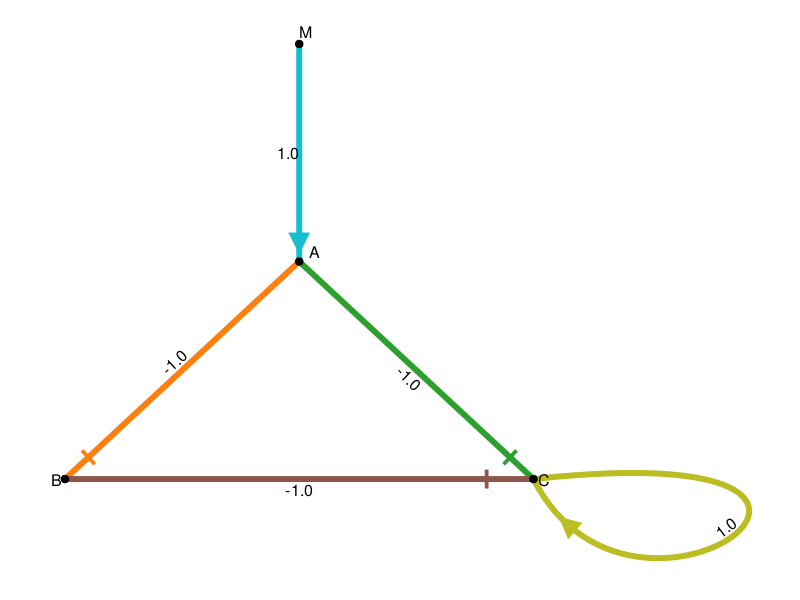

In [34]:
f,a,p = draw_grn(reshape(minimal_top[:,2],(3,4)),color_scheme)

f

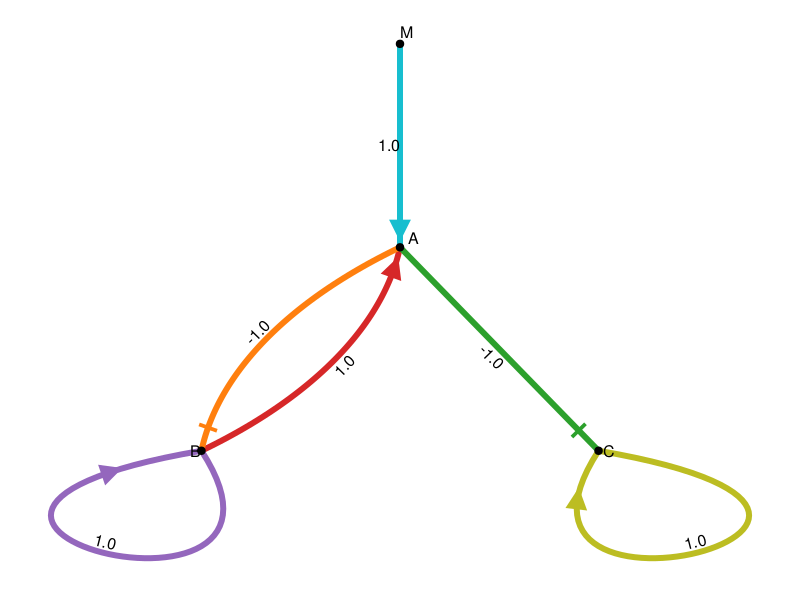

In [35]:
f,a,p = draw_grn(reshape(minimal_top[:,7],(3,4)),color_scheme)

f

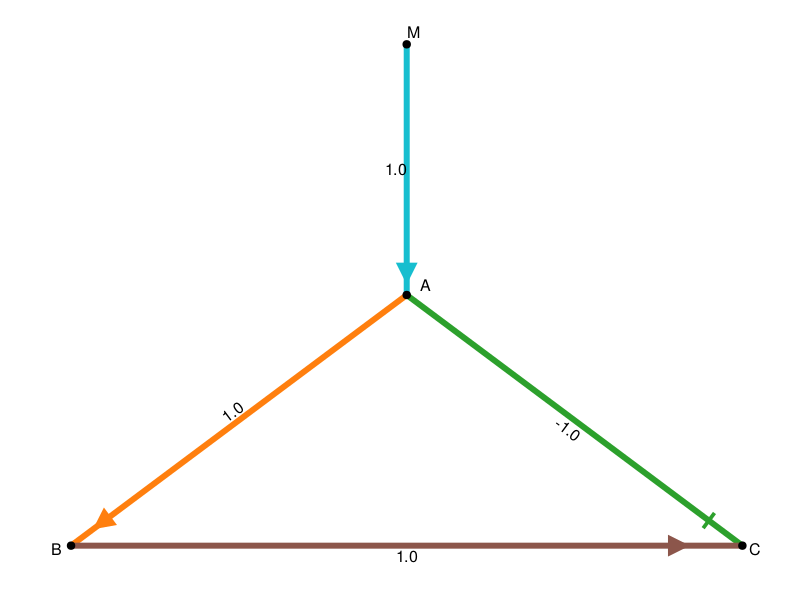

In [36]:
f,a,p = draw_grn(reshape(minimal_top[:,1],(3,4)),color_scheme)

f

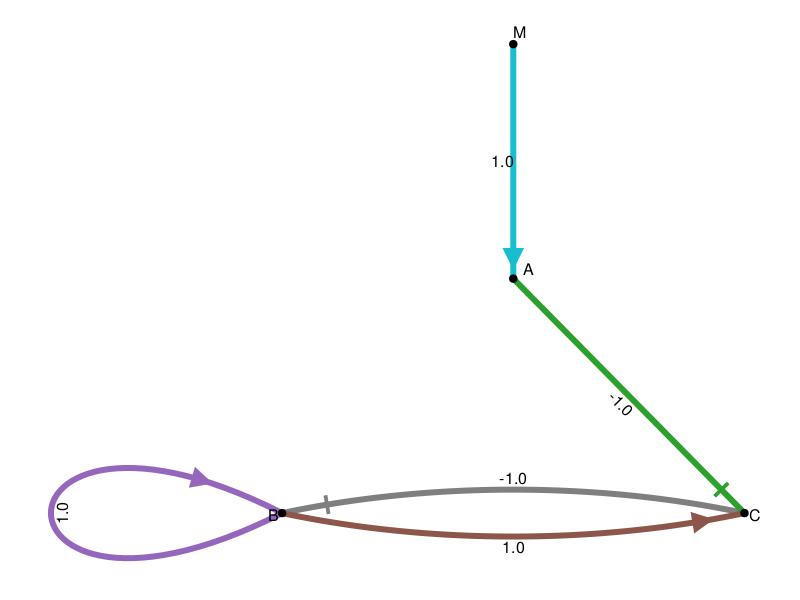

In [37]:
f,a,p = draw_grn(reshape(minimal_top[:,3],(3,4)),color_scheme)

f

In [38]:
look_id = [i in [2,7,1] for i in final_labels];

sum(look_id) / n_conv

0.9371619881534896

In [39]:
dav = dmat_av[conv,conv][look_id,look_id]

clust_labels = final_labels[look_id];

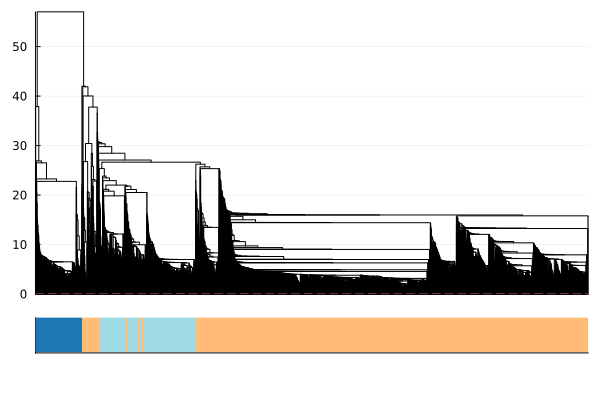

In [40]:
cu_thresh =  0

# hc1 = hclust(dav,linkage = :single,branchorder = :optimal)

hc1 = hclust(dav,linkage = :single)

# clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,length(clust_labels))),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [41]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [42]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj_add)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness_add

hist_edges[2:n_bin] .= LinRange(initial_fitness_add+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj_add);

wait_times = map(fb->unique(i -> fb[i], 1:length(fb)),fitness_traj_b)

wait_times_mutant = map(x->x[2:end] .- x[1:end-1],wait_times);

In [43]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj_add);

actual_fitness = map(x->x[1:end-1],fitness_traj);

actual_networks = map(x->[x[:,j] for j in 1:size(x[:,1:end-1],2)],geno_traj);

actual_mutant = map(x->[j for j in 1:size(x[:,1:end-1],2)],geno_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_wait_time = [[(wait_time=wt,midl...) for (wt,midl) in zip(wait_times_mutant[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_wait_time[i])] for i in 1:length(mut_id_wait_time)];

mut_id_size_label_am = [[(mut_number=mut_number,midl...) for (mut_number,midl) in zip(actual_mutant[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_an = [[(existing_network=network,midl...) for (network,midl) in zip(actual_networks[i],mut_id_size_label_am[i])] for i in 1:length(mut_id_size_label_am)];

mut_id_size_label_af = [[(existing_fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label_an[i])] for i in 1:length(mut_id_size_label_an)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=final_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [44]:
function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut_to_evaluate = length(mut_tuple[:mut_id])

    if typeof(mut_tuple[:existing_fitness]) == Tuple{Float64,Float64}
        existing_fitness = mut_tuple[:existing_fitness][1] + mut_tuple[:existing_fitness][2]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    else
        existing_fitness = mut_tuple[:existing_fitness]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    end

    new_mutant_fitness = []

    new_mutant_weight_signs = []

    new_mutant_noise_signs = []

    for n in 1:n_mut_to_evaluate

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][n],mut_tuple[:mut_size][n],mut_tuple[:mut_type][n])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness,nmf)
        push!(new_mutant_weight_signs,sign(new_network[mut_tuple[:mut_id][n]]))
        push!(new_mutant_noise_signs,sign(mut_tuple[:mut_size][n]))

    end

    accept_mutation = new_mutant_fitness .> existing_fitness

    if accept_mutation[1] & accept_mutation[2]

        if maximum(new_mutant_fitness) > og_mutant_fitness
            r1 = Dict(mt=>:nonsyn for mt in mut_tuple[:mut_id])
        else
            r1 = Dict(mt=>:syn for mt in mut_tuple[:mut_id])
        end

    elseif (accept_mutation[1] & !accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:carrier,mut_tuple[:mut_id][2]=>:hitchhike)
    elseif (!accept_mutation[1] & accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:hitchhike,mut_tuple[:mut_id][2]=>:carrier)
    else
        r1 = Dict(mt=>:rse for mt in mut_tuple[:mut_id])
    end

    return r1
end


function characterise_epi(d)
    v = values(d) |> collect

    if :rse in v
        return (1,"RSE")
    elseif :carrier in v
        return (2,"Carrier/Hitchhike")
    else
        return (3,"Syn/NonSyn")
    end

end

function mask(network,topology)

    new_network = copy(network)

    z0 = findall(x->x == 0,topology)

    new_network[z0] .= 0.

    return new_network

end

mask (generic function with 1 method)

In [45]:
hamming_distance_all = [reduce(hcat,map(en->[Distances.evaluate(Hamming(),mask(sign.(en),vec(fund_top)),vec(fund_top)) for fund_top in eachcol(minimal_top)],eachcol(geno_traj[i]))) |> collect for i in 1:length(geno_traj)];

In [46]:
md_list = map(t->findall(x->x == 0, t[:,end]),hamming_distance_all)

@assert all([fl in md for (fl,md) in zip(final_labels[final_labels .!= -1],md_list[final_labels .!= -1])])

In [47]:
stripe_achieved = map(x->minimum(findall(x->x[1] == 0.,unique(x))),fitness_traj_b);

zham_id =  map(hd->findall(y->any(y .== 0),eachcol(hd)),hamming_distance_all);

zham_achieved = [minimum(x) for x in zham_id];

In [48]:
zham_top = [findall(x->x==0,hd[:,zid]) for (zid,hd) in zip(zham_achieved,hamming_distance_all)]

zham_incl_end =  [etop in ztop for (ztop,etop) in zip(zham_top,final_labels)]

#########################

zham_trans_id =  map(x->x-1,zham_achieved)

zham_mutation = [filter(x->(x[:traj_id] == t) && (x[:mut_number] == m),all_mut_info)[1] for (t,m) in zip(1:length(hamming_distance_all),zham_trans_id)];

#########################

zham_distance_dist = [t[:,m] for (t,m) in zip(hamming_distance_all,zham_trans_id)];

zham_distance_min = map(x->minimum(x),zham_distance_dist)

zham_distance_min_top = [findall(x->x==mind,dist) for (dist,mind) in zip(zham_distance_dist,zham_distance_min)]

zham_distance_h0 = [minimum(d[id]) for (d,id) in zip(zham_distance_dist,zham_top)]

#########################

stripe_trans_id = map(x->x-1,stripe_achieved)

stripe_mutation = [filter(x->(x[:traj_id] == t) && (x[:mut_number] == m),all_mut_info)[1] for (t,m) in zip(1:length(hamming_distance_all),stripe_trans_id)];

In [49]:
zht_in_mdt = [any([zh in mdt for zh in zht]) for (mdt,zht) in zip(zham_distance_min_top,zham_top)];

In [50]:
sum(zham_incl_end) / n_conv

0.9332989956219419

In [51]:
countmap(zham_distance_h0)

Dict{Int64, Int64} with 4 entries:
  4 => 6
  2 => 2458
  3 => 121
  1 => 1298

In [52]:
mdt_vs_distance_h0 = counts(zht_in_mdt,zham_distance_h0)

2×4 Matrix{Int64}:
    0  1038  120  6
 1298  1420    1  0

In [53]:
n_mut_zham_trans = map(x->x[:n_mut],zham_mutation);

In [54]:
n_mut_vs_distance_h0 = zeros(Float64,maximum(n_mut_zham_trans),maximum(zham_distance_h0))

for dh0 in 1:maximum(zham_distance_h0)
    for n_mut in 1:maximum(n_mut_zham_trans)
        id_mut = n_mut_zham_trans .== n_mut
        id_dh0 = zham_distance_h0 .== dh0

        n_mut_vs_distance_h0[n_mut,dh0] = sum(id_mut .& id_dh0)

    end
end

In [55]:
function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut = length(mut_tuple[:mut_id])

    mut_combi = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = n_mut)] for i in 1:2^n_mut-1]

    accept_new_mutant = []

    for mut_id in mut_combi[1:end-1]

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][mut_id],mut_tuple[:mut_size][mut_id],mut_tuple[:mut_type][mut_id])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        mutant_fitness = fitness_function(mutant.phenotype)

        fix_p = fixation_probability(mutant_fitness[1] - mut_tuple[:existing_fitness][1],mutant_fitness[2] - mut_tuple[:existing_fitness][2],β)

        push!(accept_new_mutant,fix_p > 0)

    end

    rtype = :ne

    if !any(accept_new_mutant)
        rtype = :rse

    else
        for mut_id in 1:n_mut
            accept_id = findall(x->x[mut_id],mut_combi[1:end-1])
            if any([!x for x in accept_new_mutant[accept_id]])
                rtype = :se
            end
        end
    end

    return rtype
end

function evaluate_epistasis_class(mut_tuple,target_top,grn_parameters,development,fitness_function)

    n_mut = length(mut_tuple[:mut_id])

    mut_combi = [[bit == '1' ? true : false for bit in string(i;base = 2,pad = n_mut)] for i in 1:2^n_mut-1]

    accept_new_mutant = []

    for mut_id in mut_combi[1:end-1]

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][mut_id],mut_tuple[:mut_size][mut_id],mut_tuple[:mut_type][mut_id])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        mutant_fitness = fitness_function(mutant.phenotype)

        fix_p = fixation_probability(mutant_fitness[1] - mut_tuple[:existing_fitness][1],mutant_fitness[2] - mut_tuple[:existing_fitness][2],β)

        push!(accept_new_mutant,fix_p > 0)

    end

    rtype = :ne

    if !any(accept_new_mutant)
        rtype = :rse

    else
        for (mut_n,mut_id) in enumerate(mut_tuple[:mut_id])
            if any([tt[mut_id] != 0 for tt in eachcol(target_top)])
                accept_id = findall(x->x[mut_n],mut_combi[1:end-1])
                if any([!x for x in accept_new_mutant[accept_id]])
                    rtype = :se
                end
            end
        end
    end

    return rtype
end


evaluate_epistasis_class (generic function with 2 methods)

In [56]:
# epi_result_branch = map(x->evaluate_epistasis_class(x,grn_parameters,DefaultGRNSolver(),fitness_function),zham_mutation[epi_id]);

epi_id = findall(x->x[:n_mut] > 1,zham_mutation);

epi_result_branch = [evaluate_epistasis_class(m,minimal_top[:,t],grn_parameters,DefaultGRNSolver(),fitness_function) for (m,t) in zip(zham_mutation[epi_id],zham_top[epi_id])];

In [57]:
epi_count = countmap(epi_result_branch)

epi_result = zeros(3)

epi_result[1] = 100*epi_count[:rse] / length(epi_id)
epi_result[2] = 100*epi_count[:se] / length(epi_id)
epi_result[3] = 100*epi_count[:ne] / length(epi_id);

In [58]:
wait_times = map(x->x[:wait_time],zham_mutation[epi_id])

low_wait = zeros(3)
mean_wait = zeros(3)
high_wait = zeros(3)

for (n,rtype) in enumerate([:rse,:se,:ne])
    dwait = wait_times[epi_result_branch .== rtype]

    m_dwait = mean(dwait)
    sd_dwait = std(dwait) / sqrt(length(dwait))

    low_wait[n] = m_dwait - sd_dwait
    mean_wait[n] = m_dwait
    high_wait[n] = m_dwait + sd_dwait
end

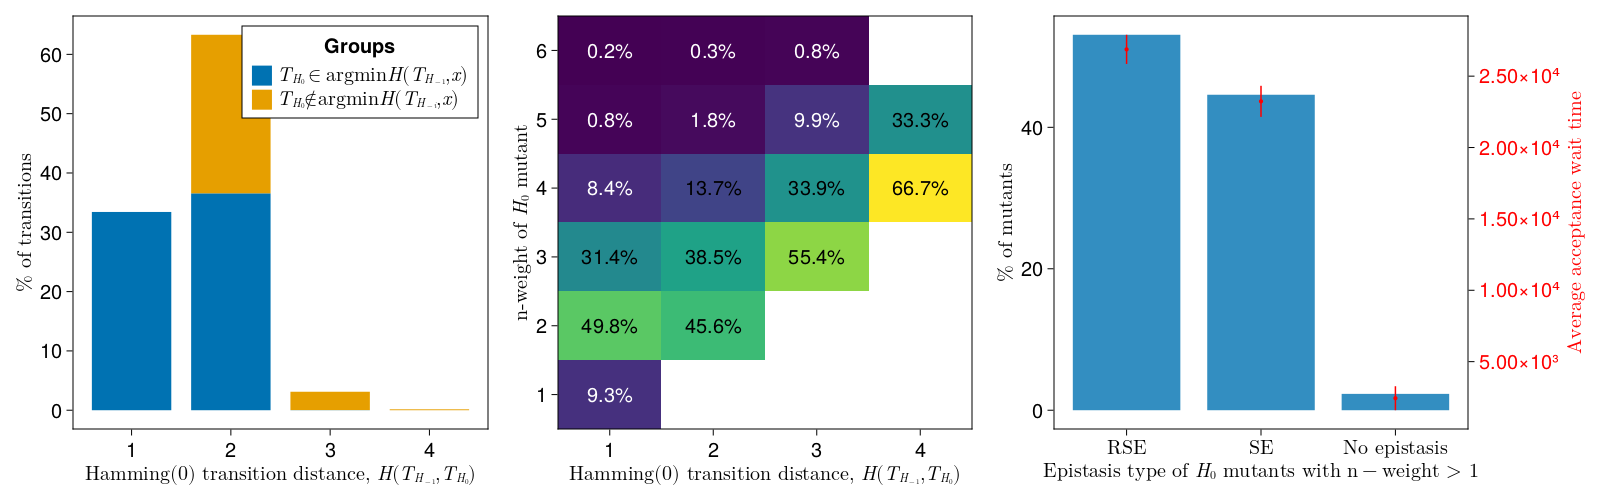

In [59]:
colors = Makie.wong_colors()

for_report = false

# https://discourse.julialang.org/t/makie-how-to-make-a-figure-with-exactly-correct-font-size/79553

if for_report 
    size_inches = (6, 9)
    size_pt = 72 .* size_inches

    font_size = 12.

    fig = CairoMakie.Figure(resolution = size_pt,fontsize = font_size)

    id1 = (1,1)
    id2 = (2,1)
    id3 = (3,1)
else

    font_size = 20.

    fig = CairoMakie.Figure(resolution = (1600,500),fontsize = font_size)

    id1 = (1,1)
    id2 = (1,2)
    id3 = (1,3)
end

ax1 = Axis(fig[id1...], xlabel = L"Hamming(0) transition distance, $H(T_{H_{-1}},T_{H_{0}})$", ylabel = L"\text{% of transitions}")

is_not_mdt = mdt_vs_distance_h0[1,:]
is_mdt = mdt_vs_distance_h0[2,:]

sub_cat = [is_mdt,is_not_mdt]

bar_x = reduce(vcat,[[i for i in 1:maximum(zham_distance_h0)] for _ in sub_cat])

bar_stack = reduce(vcat,[[n for _ in c] for (n,c) in enumerate(sub_cat)])

bar_values = reduce(vcat,sub_cat)

bar_values_p = 100 .* bar_values ./ sum(bar_values)

CairoMakie.barplot!(ax1,bar_x,bar_values_p,stack = bar_stack,color = colors[bar_stack])

labels = [L"$T_{H_{0}} \in \text{argmin} H(T_{H_{-1}},x)$", L"$T_{H_{0}} \notin \text{argmin} H(T_{H_{-i}},x)$"]
elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]
title = "Groups"

axislegend(ax1,elements, labels, title)

hidedecorations!(ax1,ticks = false,ticklabels = false,label = false)

##############

dplot = n_mut_vs_distance_h0 ./ sum(n_mut_vs_distance_h0,dims = 1)

dplot = dplot |> transpose |> collect

dplot[dplot .== 0] .= NaN

ax2 = Axis(fig[id2...], xlabel = L"Hamming(0) transition distance, $H(T_{H_{-1}},T_{H_{0}})$", ylabel = L"n-weight of $H_{0}$ mutant")
CairoMakie.heatmap!(ax2,dplot)

text!(
    map(x->isnan(x) ? "" : string(round(100*x,digits = 1)) * "%",vec(dplot')),
    position = [Point2f(x, y) for x in 1:size(dplot,1) for y in 1:size(dplot,2)],
    align = (:center,:center),
    color = ifelse.(dplot' .< 0.1, :white, :black),
    fontsize = font_size,
    )

ax2.xticks = (1:6, string.(1:6))
ax2.yticks = (1:6, string.(1:6))

hidedecorations!(ax2,ticks = false,ticklabels = false,label = false)

##############

ax3 = Axis(fig[id3...], xlabel = L"$\text{Epistasis type of } H_{0} \text{ mutants with n-weight > 1}$", ylabel = L"\text{% of mutants}")
ax4 = Axis(fig[id3...], yticklabelcolor = :red, ylabelcolor = :red, yaxisposition = :right,backgroundcolor = :transparent, ylabel = L"\text{Average acceptance wait time}")

hidexdecorations!(ax4)
hidespines!(ax4)
linkxaxes!(ax3, ax4)

CairoMakie.barplot!(ax3,[1,2,3],epi_result)
CairoMakie.rangebars!(ax4,[1,2,3],low_wait,high_wait,color = :red)
CairoMakie.scatter!(ax4,mean_wait,markerstyle = "x",color = :red,markersize = 6.)

ax3.xticks = (1:3, [L"\text{RSE}",L"\text{SE}",L"\text{No epistasis}"])

hidedecorations!(ax3,ticks = false,ticklabels = false,label = false)
hidedecorations!(ax4,ticks = false,ticklabels = false,label = false)

if for_report

    save(plotsdirx("Experiment_1/Report","HammingZeroTransitionSummary.pdf"),fig,pt_per_unit = 1)
end

fig

In [67]:
function check_minimal_top(n_mut,zham_top,zham_trans_id,hamming_distance_all,final_labels)

    keep_positive_trans = findall(x->x > 0,zham_trans_id .- n_mut)

    zham_distance_dist = [t[:,m-n_mut] for (t,m) in zip(hamming_distance_all[keep_positive_trans],zham_trans_id[keep_positive_trans])];

    zham_distance_min = map(x->minimum(x),zham_distance_dist)

    zham_distance_min_top = [findall(x->x==mind,dist) for (dist,mind) in zip(zham_distance_dist,zham_distance_min)]

    zham_distance_h0 = [minimum(d[id]) for (d,id) in zip(zham_distance_dist,zham_top[keep_positive_trans])]

    zht_in_mdt = [any([zh in mdt for zh in zht]) for (mdt,zht) in zip(zham_distance_min_top,zham_top[keep_positive_trans])];

    return zht_in_mdt, final_labels[keep_positive_trans]
end

check_minimal_top (generic function with 2 methods)

In [80]:
n_mut_prev = 6

all_inclusion_tests = []
all_fl_counts = []

fl_id = [2,7,1]

for i in 1:n_mut_prev
    incl_test,fl = check_minimal_top(i,zham_top,zham_trans_id,hamming_distance_all,final_labels)

    fl_counts = zeros(length(fl_id)+1)

    for i in 1:length(fl_id)
        fl_counts[i] = count(x->x==fl_id[i],fl)
    end

    fl_counts[end] = length(fl) - sum(fl_counts)

    push!(all_inclusion_tests,counts(incl_test))
    push!(all_fl_counts,fl_counts)
end

inclusion_test = reduce(hcat,all_inclusion_tests)

fl_counts = reduce(hcat,all_fl_counts)

fl_counts_p = fl_counts ./ sum(fl_counts,dims = 1);

In [86]:
baseline_performance = (inclusion_test ./ sum(inclusion_test,dims = 1))[2,:];
sample_sizes = sum(inclusion_test,dims = 1);

In [118]:
using ScikitLearn: @sk_import, fit!, predict

@sk_import utils.class_weight : compute_sample_weight

PyObject <function compute_sample_weight at 0x22b9030a0>

In [516]:
function get_data(n_mut,zham_trans_id,geno_traj,t2s_traj,final_labels,keep_id)

    keep_positive_trans = findall(x->x > 0,zham_trans_id .- n_mut) ∩ findall(x->x in keep_id,final_labels)

    gt = [g[:,m-n_mut] for (g,m) in zip(geno_traj[keep_positive_trans],zham_trans_id[keep_positive_trans])];

    t2s = [t[m-n_mut] for (t,m) in zip(t2s_traj[keep_positive_trans],zham_trans_id[keep_positive_trans])];

    X = reduce(hcat,gt)

    y = copy(final_labels[keep_positive_trans])

    y_sample_id = [shuffle(findall(x->x==label,y)) for label in unique(y)]

    train_test_split = 0.8

    n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

    y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

    train_id = reduce(vcat,y_train_id )
    test_id = reduce(vcat,y_test_id );

    return X[1:10,train_id] |> transpose |> collect ,X[1:10,test_id] |> transpose |> collect,y[train_id],y[test_id],t2s[train_id],t2s[test_id]
end

function create_leave_one_vs_rest_labels(y_train,keep_id)

    return [Int.(y_train .== id) for id in keep_id]

end

create_leave_one_vs_rest_labels (generic function with 1 method)

In [517]:
keep_id = [2,7,1]

3-element Vector{Int64}:
 2
 7
 1

In [518]:
weight_names

10-element Vector{String}:
 "A=>A"
 "A=>B"
 "A=>C"
 "B=>A"
 "B=>B"
 "B=>C"
 "C=>A"
 "C=>B"
 "C=>C"
 "M=>A"

In [519]:
xg_test_accuracy = []

all_models = []

all_train = []

all_test = []

for n_mut_prev in 0:5
    X_train,X_test,y_train,y_test,t2s_train,t2s_test = get_data(n_mut_prev,zham_trans_id,geno_traj,data["t2s_traj"][conv],final_labels,keep_id);

    ovr_train_labels = create_leave_one_vs_rest_labels(y_train,keep_id);
    ovr_test_labels = create_leave_one_vs_rest_labels(y_test,keep_id);

    c_types = ["c" for _ in 1:size(X_train,2)];

    model_list = []
    confusion_train = []
    confusion_test = []

    for (n_top,top) in enumerate(keep_id)

        y_train_ovr = copy(ovr_train_labels[n_top])
        y_test_ovr = copy(ovr_test_labels[n_top])

        d_train = xgboost.DMatrix(X_train, label=y_train_ovr, feature_types = c_types, feature_names = weight_names)
        d_test = xgboost.DMatrix(X_test, label=y_test_ovr, feature_types = c_types,  feature_names = weight_names)
        
        class_inbalance = sum(y_train_ovr .== 0) / sum(y_train_ovr .== 1)

        # class_inbalance = 1.
        
        params = Dict(
            "eta"=> 0.01,
            "objective"=>"binary:logistic",
            "subsample"=> 0.5,
            "eval_metric"=>"auc","scale_pos_weight" => class_inbalance
        )
        
        model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

        y_pred_train = Int.(model.predict(d_train) .> 0.5);
        y_pred_test = Int.(model.predict(d_test) .> 0.5);

        push!(confusion_train,counts(y_pred_train,y_train_ovr))
        push!(confusion_test,counts(y_pred_test,y_test_ovr))

        push!(model_list,model)
    end

    push!(all_models,model_list)
    push!(all_train,(X_train,y_train,t2s_train))
    push!(all_test,(X_test,y_test,t2s_test))

    d_train = xgboost.DMatrix(X_train, feature_types = c_types, feature_names = weight_names)
    d_test = xgboost.DMatrix(X_test, feature_types = c_types, feature_names = weight_names)

    final_train_pred = mapslices(x->keep_id[argmax(x)],reduce(hcat,[md.predict(d_train) for md in model_list]),dims =2);
    final_test_pred = mapslices(x->keep_id[argmax(x)],reduce(hcat,[md.predict(d_test) for md in model_list]),dims =2);

    push!(xg_test_accuracy,sum(final_test_pred .== y_test) / length(y_test))

end

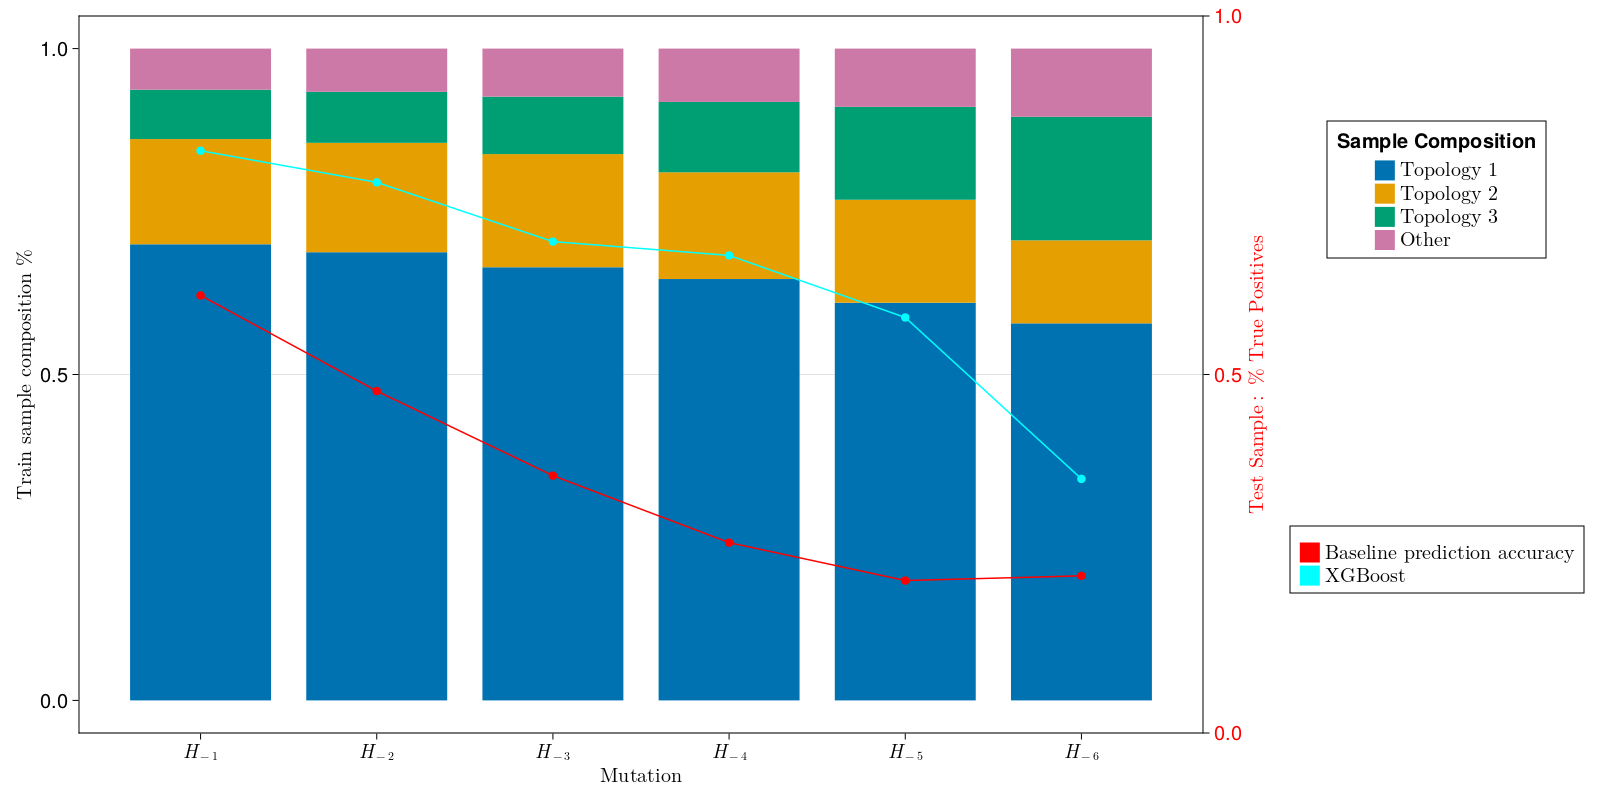

In [520]:
for_report = false

# https://discourse.julialang.org/t/makie-how-to-make-a-figure-with-exactly-correct-font-size/79553

if for_report 
    size_inches = (6, 9)
    size_pt = 72 .* size_inches

    font_size = 12.

    fig = CairoMakie.Figure(resolution = size_pt,fontsize = font_size)

    id1 = (1,1)
    id2 = (2,1)
    id3 = (3,1)
else

    font_size = 20.

    fig = CairoMakie.Figure(resolution = (1600,800),fontsize = font_size)

    id1 = (1:2,1)
    id2 = (1,2)
    id3 = (1,3)
end

ax1 = Axis(fig[id1...], xlabel = L"\text{Mutation}", ylabel = L"\text{Train sample composition %}")

sub_cat = [fl_counts_p[i,:] for i in 1:size(fl_counts,1)]

bar_x = reduce(vcat,[[i for i in 1:length(baseline_performance)] for _ in sub_cat])

bar_stack = reduce(vcat,[[n for _ in c] for (n,c) in enumerate(sub_cat)])

bar_values = reduce(vcat,sub_cat)

CairoMakie.barplot!(ax1,bar_x,bar_values,stack = bar_stack,color = colors[bar_stack])

# text!(
#     map(x->string(round(100*x,digits = 1)) * "%",baseline_performance),
#     position = [Point2f(x, Int(floor(0.8*baseline_performance[x]*sample_sizes[x]))) for x in 1:n_mut_prev],
#     align = (:center,:center),
#     color = :white,
#     fontsize = font_size,
#     )

labels = [L"\text{Topology 1}", L"\text{Topology 2}",L"\text{Topology 3}",L"\text{Other}"]
elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]
title = "Sample Composition"

leg = Legend(fig[1,2],elements, labels, title)

hidedecorations!(ax1,ticks = false,ticklabels = false,label = false)

ax1.xticks = (1:length(baseline_performance),[L"H_{-1}",L"H_{-2}",L"H_{-3}",L"H_{-4}",L"H_{-5}",L"H_{-6}"])


#####################

ax2 = Axis(fig[id1...], yticklabelcolor = :red, ylabelcolor = :red, yaxisposition = :right,backgroundcolor = :transparent, ylabel = L"\text{Test Sample: % True Positives}",limits = (nothing,nothing,0.,1.))

hidexdecorations!(ax2)
hidespines!(ax2)
linkxaxes!(ax1, ax2)

CairoMakie.lines!(ax2,baseline_performance, color = :red)
CairoMakie.scatter!(ax2,baseline_performance, color = :red)

CairoMakie.lines!(ax2,Float64.(xg_test_accuracy), color = :cyan)
CairoMakie.scatter!(ax2,Float64.(xg_test_accuracy), color = :cyan)

labels = [L"\text{Baseline prediction accuracy}",L"\text{XGBoost}"]
elements = [PolyElement(polycolor = :red),PolyElement(polycolor = :cyan)]
title = ""

leg = Legend(fig[2,2],elements, labels, title)


fig

In [ ]:
# https://ieeexplore.ieee.org/abstract/document/10191053

In [521]:
n_mut_prev = 2

2

In [522]:
model_look = all_models[n_mut_prev];

d_train = xgboost.DMatrix(all_train[n_mut_prev][1], feature_types = c_types, feature_names = weight_names)

PyObject <xgboost.core.DMatrix object at 0x24a716260>

In [523]:
shap_values = [model.predict(d_train,pred_contribs = true) for model in model_look];

In [524]:
# shap_values_int = [model.predict(d_train,pred_interactions = true) for model in model_look];

In [533]:
X_train = all_train[n_mut_prev][1] |> transpose |> collect

X_train_n = vcat(X_train,zeros(2,size(X_train,2)))

branch_networks = [t |> collect for t in eachcol(X_train_n)];

In [560]:
y_train = copy(all_train[n_mut_prev][2]);

In [536]:
branch_t2s = copy( all_train[n_mut_prev][3]);

In [538]:
branch_dyn_av = pmap(nt->get_av_dyn_vector(reshape(nt[1],(3,4)),nt[2],n_steps,n_segments),zip(branch_networks,branch_t2s));

branch_X_av = reduce(hcat,branch_dyn_av);

branch_dmat = pairwise(d_metric,branch_X_av,branch_X_av,dims = 2);

In [568]:
shap_dmat = pairwise(d_metric,all_shap_train,all_shap_train,dims = 2);
shap_dmat_ham = pairwise(Hamming(),sign.(all_shap_train),sign.(all_shap_train),dims = 2);

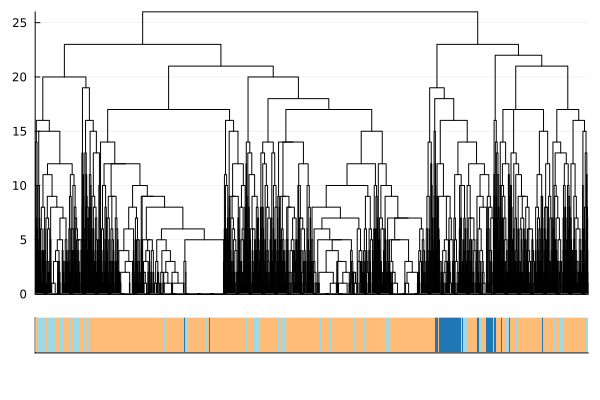

In [571]:
cu_thresh =  0

# hc1 = hclust(dav,linkage = :single,branchorder = :optimal)

hc1 = hclust(shap_dmat_ham,linkage = :complete)

# clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(y_train[hc1.order],(1,length(y_train))),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab20,categorical = true))

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(2, 1,heights=[0.8,0.1])]

p_all = StatsPlots.plot(p1, p2, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [599]:
lda = MultivariateStats.fit(MultivariateStats.MulticlassLDA, X_train, y_train; outdim=2)
Ylda = MultivariateStats.predict(lda, X_train)

2×2887 Matrix{Float64}:
 -0.0423715   0.0167223  0.00762891  …  0.0484481  0.0100536  0.0407109
  0.00300616  0.0108041  0.0135627      0.0431803  0.011288   0.0335254

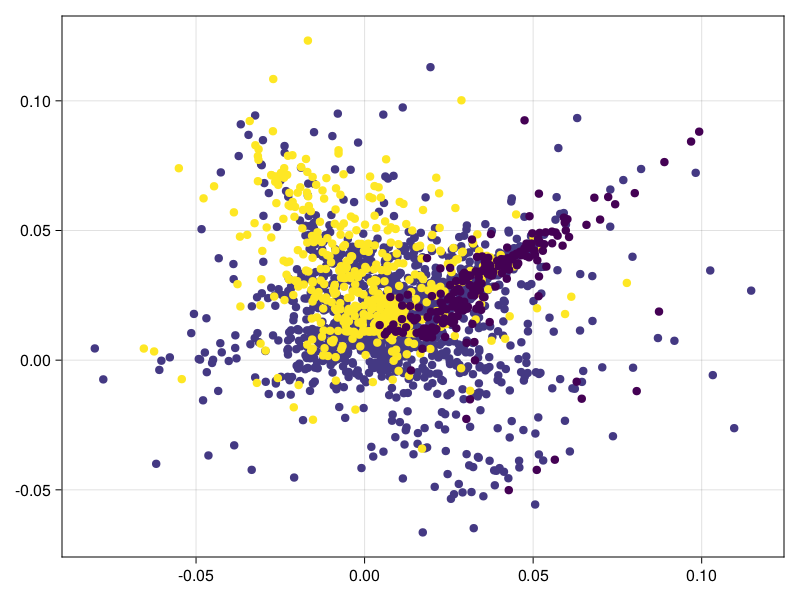

In [600]:
CairoMakie.scatter(Ylda,color = y_train)

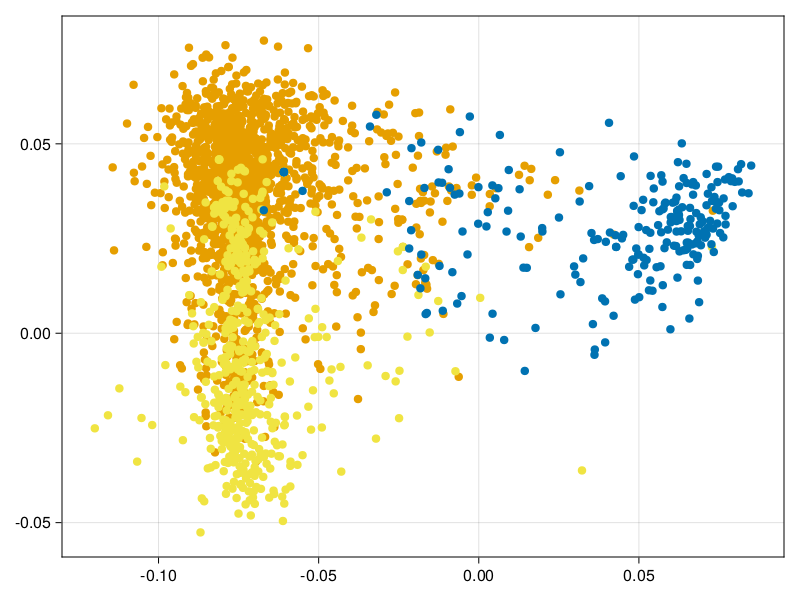

In [610]:
lda = MultivariateStats.fit(MultivariateStats.MulticlassLDA, all_shap_train, y_train; outdim=2)
Ylda = MultivariateStats.predict(lda,  all_shap_train)

CairoMakie.scatter(Ylda,color = [colors[i] for i in y_train])

In [614]:
classmeans(lda)

30×3 Matrix{Float32}:
  0.00327229   0.00016446   0.000488753
  0.042547    -0.0366727   -0.387503
  0.0344524   -0.00490268  -0.0433636
  0.188431    -0.442282     0.0955216
  0.061127    -0.0828562    0.0148969
  0.211205     0.107416    -0.652175
  0.00578066  -0.00228545  -0.00676398
  0.037357    -0.00532103  -0.109422
  0.126066     0.0617405   -0.0817367
  0.0334346   -0.00277561  -0.0209142
  ⋮                        
 -0.371096    -0.278447     0.307008
 -0.114479    -0.102369     0.0202044
 -0.0547817   -0.226548     0.0148269
 -0.0982397   -0.16836      0.0774404
 -1.10937     -1.05395      0.819123
 -0.0230977   -0.0243898   -0.00413733
 -0.0606493   -0.051808     0.089661
 -0.367702    -0.512672     0.309976
 -0.0315285   -0.0316098   -0.022533